In [1]:
# TODO: Install graphviz
# !sudo apt install graphviz
# !pip install graphviz

# Reproducing the presidential height example

In the Bayes' factors tutorial, everyone saw an example of hypothesis testing for the correlation between a president's height and their popular vote share at election. Using the same data, we'll use Bayesian parameter estimation to compute the full posterior over the correlation.

## Imports and config

In [2]:
# Standard libraries
import os
import warnings

# The usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Bayes libraries
# Arviz is a plotting package for common figures in Bayesian analysis
# PyMC3 is a Python PPL based on Theano; provides distributions and NUTS sampler.
# Theano is a numerical compute library that supports autodifferention and CUDA

import arviz as az
import pymc3 as pm

from theano import tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Suppress FutureWarnings raised by Theano
warnings.filterwarnings('ignore', category=FutureWarning)

# Use most CPU cores if available
CORES = min(4, os.cpu_count() - 1)

# Set random seed
SEED = 3264602
np.random.seed(SEED)

## Load dataset

This is the same dataset provided by Ronald van den Berg as an example in his talk on Bayes' factors. It contains missing heights and vote shares for some presidents.

(Notably, vote shares are missing for presidents who came into office as a result of deaths, assassinations, impeachments, etc.)

In [4]:
# Load data
df = pd.read_csv('../data/presidents_original.tsv', sep='\t')
print('# Original records', len(df))
df.sample(n=10)

# Original records 61


,President,Election year,HeightRatio,PopVoteRatio
11,Andrew Jackson,1832,1.000000,0.597142
36,Woodrow Wilson,1916,1.011236,0.516359
30,Grover Cleveland,1892,1.071429,0.516904
24,Ulysses S. Grant,1872,0.971910,0.559380
9,John Quincy Adams,1824,0.924324,0.427781
54,Ronald Reagan,1984,1.027778,0.591664
44,Harry S. Truman,1948,1.011561,0.523674
25,Rutherford B. Hayes,1876,0.977528,0.484824
46,Dwight D. Eisenhower,1956,1.005618,0.577512
13,William Henry Harrison,1840,1.029762,0.530344


In [5]:
# Drop rows with missing data
df.dropna(subset=('HeightRatio', 'PopVoteRatio'), inplace=True)
print('# Complete records', len(df))
df.sample(n=10)

# Complete records 46


,President,Election year,HeightRatio,PopVoteRatio
33,Theodore Roosevelt,1904,1.017143,0.600149
37,Warren G. Harding,1920,1.089286,0.638510
28,Grover Cleveland,1884,1.000000,0.502934
45,Dwight D. Eisenhower,1952,1.005618,0.554517
54,Ronald Reagan,1984,1.027778,0.591664
57,Bill Clinton,1996,1.005348,0.547304
26,James A. Garfield,1880,0.978610,0.500466
47,John F. Kennedy,1960,1.005495,0.500856
9,John Quincy Adams,1824,0.924324,0.427781
11,Andrew Jackson,1832,1.000000,0.597142


## Uniform prior model

The uniform model, from the Bayes' factor tutorial, uses a uniform priors over a region of the correlation parameter space.

### Model specification

Sample from priors on mean, standard deviations, and correlation:
$$\mu_{height} \sim N(\mu=1, \sigma=.1)$$
$$\mu_{vote} \sim Beta(\mu=.5, \sigma=.25)$$
$$\sigma_{height} \sim HalfCauchy(\sigma=2.5)$$
$$\sigma_{vote} \sim HalfCauchy(\sigma=2.5)$$
$$\rho \sim U(l, b)$$

Transform standard deviations and correlation into a covariance matrix:
$$\sigma = \begin{bmatrix} \sigma_{height} & \sigma_{vote} \end{bmatrix}$$

$$\Sigma = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix} \odot (\sigma \times \sigma^T)$$

$$\mathbf{\mu} = \begin{bmatrix} \mu_{height} & \mu_{vote} \end{bmatrix}$$

Sample from multivariate normal likelihood:
$$height, vote \sim N(\mathbf{\mu}, \Sigma)$$

### Implementation

In [6]:
def create_uniform_model(data=None, 
                         lower=-1, upper=1,  
                         mu_height=None, mu_vote=None,
                         sigma_height=None, sigma_vote=None):
    
    # Enter model context - basically, registers sampling operations
    # on following distributions
    with pm.Model() as model:
        # Sample from priors if not specified
        if mu_height is None:
            # Height seems tightly distributed around 1
            # (It would be reasonable to standardize height data,
            #  but I'm not sure whether the OP did that in their own analysis)
            mu_height = pm.Normal('mu_height', mu=1, sigma=.1)
            
        if mu_vote is None:
            # Vote is in (0, 1) and is a proportion, so I use a beta prior
            mu_vote = pm.Beta('mu_vote', mu=.5, sigma=.25)

        if sigma_height is None:
            sigma_height = pm.HalfCauchy("sigma_height", 2.5)
        
        if sigma_vote is None:
            sigma_vote = pm.HalfCauchy("sigma_vote", 2.5)
        
        # Sample correlation coefficient
        corr = pm.Uniform("corr", lower, upper)
        
        # Compute covariance matrix from standard deviations and correlation
        cov = tt.eye(2)
        cov = cov + (1 - cov) * corr
        sigmas = tt.stack([sigma_height, sigma_vote])
        cov = cov * tt.outer(sigmas, sigmas.T) 
                
        # Bivariate normal likelihood function
        obs = pm.MvNormal("obs", 
                          mu=(mu_height, mu_vote), cov=cov, 
                          observed=data)
        
    return model

### Instantiate models

In [7]:
# Retrieve data matrix from dataframe
data = df.loc[:, ['HeightRatio', 'PopVoteRatio']].values

# Create model with desired parameters
full_prior_model = create_uniform_model(data=data, lower=-1, upper=1)
positive_prior_model = create_uniform_model(data=data, lower=0, upper=1)
negative_prior_model = create_uniform_model(data=data, lower=-1, upper=0)

### Visualize graph

In [8]:
pm.model_to_graphviz(model=full_prior_model);

### Posterior inference

We use NUTS to draw samples from the posterior. `trace` is a record of sampled values for each variable declared in the model.

In [9]:
def sample_from_model(model, tune=2500, draws=2000, chains=4):
    with model:
        # Configure MCMC kernel if desired
        step = pm.NUTS()
        
        # Draw 1000 samples after 1000 step burn-in, using 4 chains in parallel
        trace = pm.sample(step=step, tune=tune, draws=draws, chains=chains,
                          cores=CORES, random_seed=SEED)
        
    return trace

In [10]:
full_prior_trace = sample_from_model(full_prior_model)
positive_prior_trace = sample_from_model(positive_prior_model, )
negative_prior_trace = sample_from_model(negative_prior_model)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [corr, sigma_vote, sigma_height, mu_vote, mu_height]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:12<00:00, 1410.40draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [corr, sigma_vote, sigma_height, mu_vote, mu_height]
Sampling 4 chains, 1 divergences: 100%|██████████| 18000/18000 [00:14<00:00, 1232.24draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6810782997705696, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6992863915704524, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [corr, sigma_vote, sigma_height, mu_vote, mu_height]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:14<00:00, 1238.75draws/s]


### Inspect trace

Checking the trace helps confirm that the sampler has converged correctly. Usually not an issue with simpler models, but good to know about and appropriate to have ready for supporting materials.

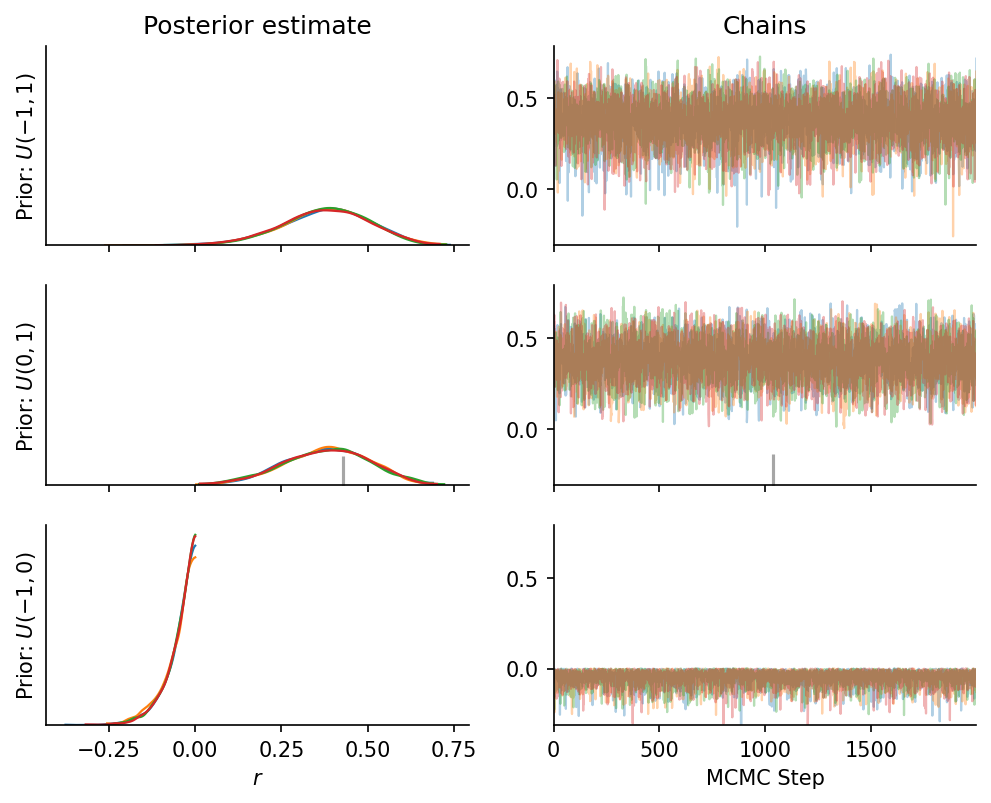

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), dpi=150, 
                         sharex='col', sharey='col')

az.plot_trace(full_prior_trace, var_names='corr', ax=axes[0:1, :], )
az.plot_trace(positive_prior_trace, var_names='corr', ax=axes[1:2, :])
az.plot_trace(negative_prior_trace, var_names='corr', ax=axes[2:3, :])

plt.setp(axes, title='')
plt.setp(axes[0, 0], title='Posterior estimate', ylabel='Prior: $U(-1, 1)$')
plt.setp(axes[1, 0], ylabel='Prior: $U(0, 1)$')
plt.setp(axes[2, 0], xlabel='$r$', ylabel='Prior: $U(-1, 0)$')
plt.setp(axes[0, 1], title='Chains')
plt.setp(axes[2, 1], xlabel='MCMC Step')

sns.despine();

### Posterior summary

Statistics for variables and sampler.

In [12]:
pm.summary(full_prior_trace, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_height,1.011,0.008,0.994,1.027,0.000,0.000,6243.0,6243.0,6255.0,5206.0,1.0
mu_vote,0.549,0.007,0.535,0.562,0.000,0.000,5731.0,5731.0,5736.0,5832.0,1.0
sigma_height,0.056,0.006,0.045,0.068,0.000,0.000,6576.0,6196.0,7004.0,5942.0,1.0
sigma_vote,0.047,0.005,0.037,0.057,0.000,0.000,6060.0,6012.0,6221.0,5814.0,1.0
corr,0.376,0.127,0.126,0.618,0.002,0.001,6965.0,6555.0,6852.0,5563.0,1.0


In [13]:
pm.summary(positive_prior_trace, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_height,1.011,0.008,0.995,1.028,0.000,0.000,5135.0,5134.0,5141.0,4921.0,1.0
mu_vote,0.549,0.007,0.534,0.562,0.000,0.000,5426.0,5426.0,5444.0,5051.0,1.0
sigma_height,0.056,0.006,0.044,0.068,0.000,0.000,4757.0,4641.0,4918.0,4953.0,1.0
sigma_vote,0.047,0.005,0.037,0.057,0.000,0.000,4767.0,4604.0,5025.0,4431.0,1.0
corr,0.379,0.124,0.136,0.615,0.002,0.001,4987.0,4987.0,5004.0,3899.0,1.0


In [14]:
pm.summary(negative_prior_trace, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_height,1.011,0.008,0.995,1.027,0.000,0.0,7030.0,7027.0,7030.0,5231.0,1.0
mu_vote,0.549,0.007,0.535,0.563,0.000,0.0,7020.0,7020.0,7045.0,5777.0,1.0
sigma_height,0.056,0.006,0.044,0.068,0.000,0.0,7245.0,6958.0,7601.0,5734.0,1.0
sigma_vote,0.047,0.005,0.037,0.058,0.000,0.0,6438.0,6232.0,6687.0,5332.0,1.0
corr,-0.049,0.045,-0.141,-0.000,0.001,0.0,6463.0,5973.0,4859.0,3425.0,1.0


### Inspect posterior distribution

This is the heart of the report - a full posterior distribution over the parameter of interest. In this case, we find expectation and 95% HPD credible region to be quite close to that found by the Bayes' factor approach.

#### Figure components

- The histogram shows posterior samples for the correlation coefficient, and the displayed mean is the expectation of those samples. 
- The orange line and text are set by the `ref_val` argument; the text is the proportion of probability mass on either side of the reference value.
- The black bar at the bottom shows the extend of the 95% **H**ighest **P**robability **D**ensity credible region.
- The green bar bar shows the **R**egion **O**f **P**ractical **E**quivalence, a range of values we might consider too low-magnitude to be of interest.
    - **NB**: The ROPE is subjective - you might have different tolerances in different circumstances. For example, the ROPE on parameters in logistic regression will have a different scale and interpretation than that for a linear regression.



In [15]:
def plot_posterior(trace, name, ax):
    az.plot_posterior(trace, var_names=['corr'],
                      kind='hist', point_estimate='median', round_to=3,
                      ref_val=0, credible_interval=.95, rope=(-.1, .1),
                      edgecolor='white', ax=ax)
    
    plt.setp(ax, title=name)
    return ax

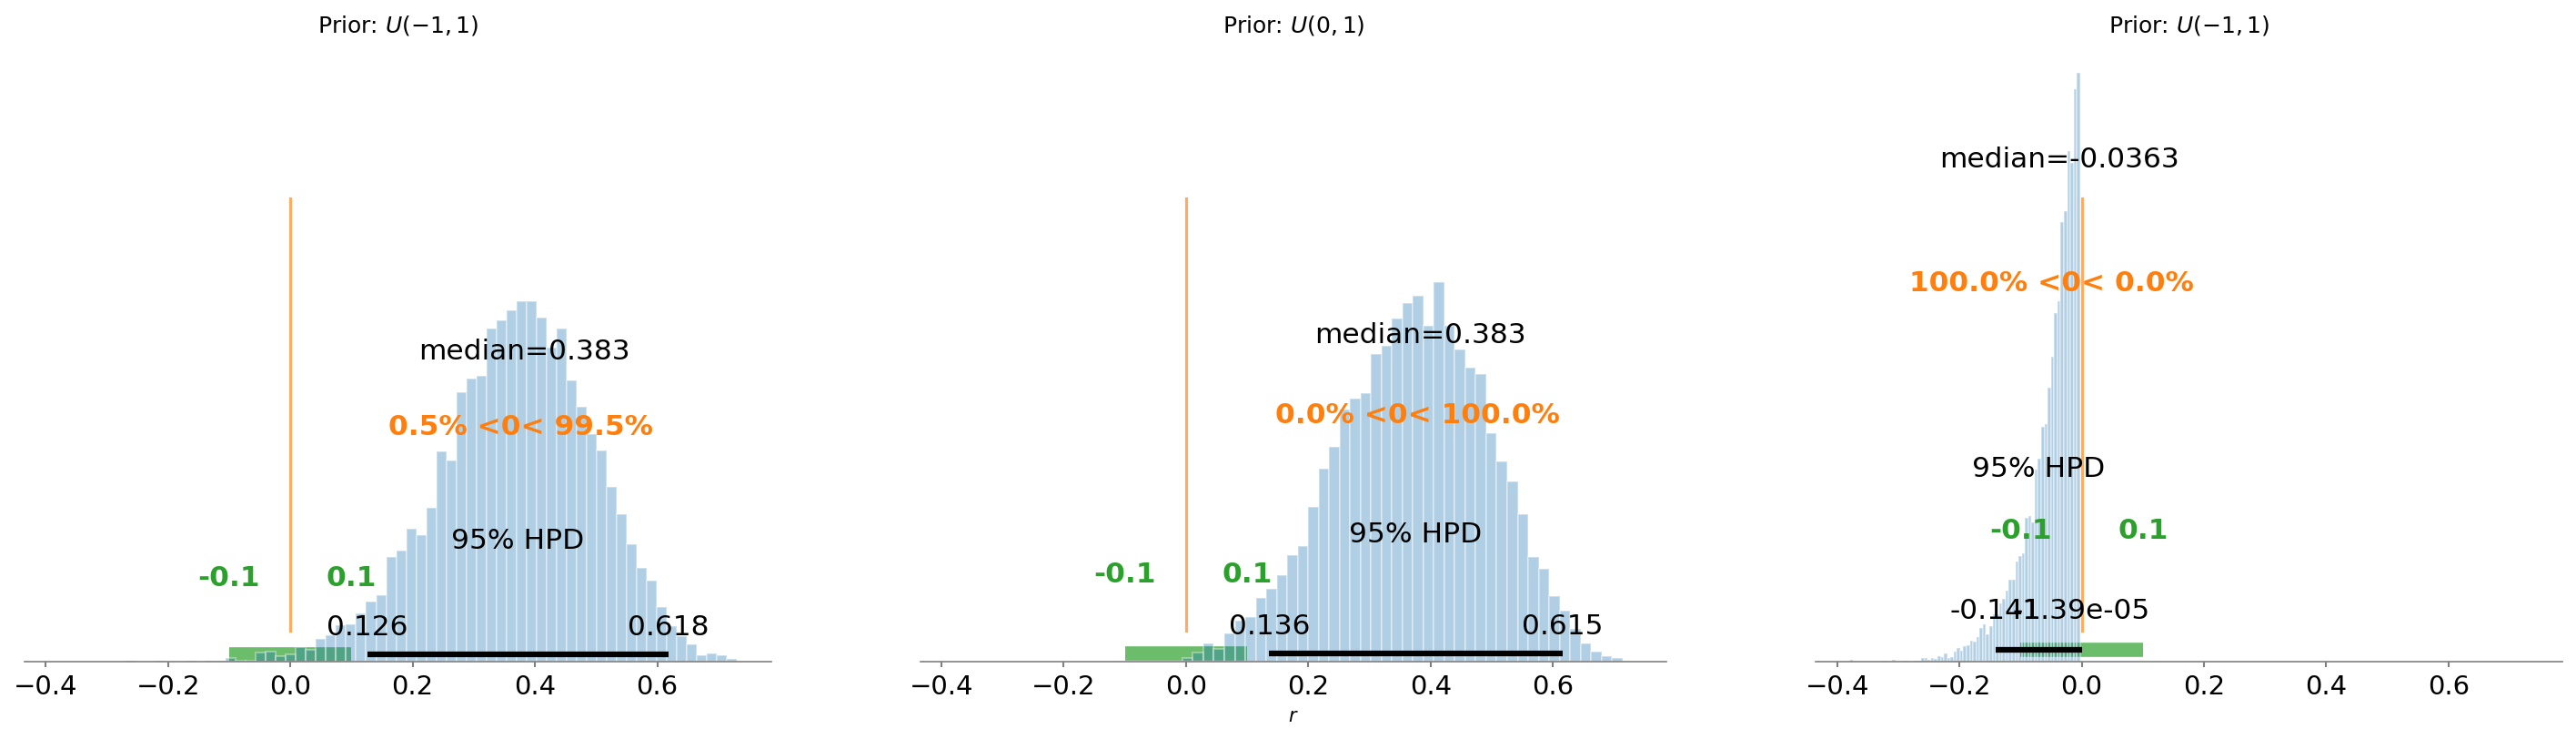

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=150, 
                         sharex=True, sharey=True)

plot_posterior(full_prior_trace, 'Prior: $U(-1, 1)$', axes[0])
plot_posterior(positive_prior_trace, 'Prior: $U(0, 1)$', axes[1])
plot_posterior(negative_prior_trace, 'Prior: $U(-1, 1)$', axes[2])

plt.setp(axes[1], xlabel='$r$');

### Posterior predictive check

How well does the posterior capture the data?

#### Sample from the posterior

In [17]:
def sample_posterior(model, trace, num_samples=25000):
    with model:
        samples = pm.sample_posterior_predictive(trace, samples=num_samples)
        
    # For convenience, we'll use a DataFrame to organize the samples
    samples = pd.DataFrame(samples['obs'], columns=['HeightRatio', 'PopVoteRatio'])
    
    return samples

In [18]:
full_prior_samples = sample_posterior(full_prior_model, full_prior_trace)
positive_prior_samples = sample_posterior(positive_prior_model, positive_prior_trace)
negative_prior_samples = sample_posterior(negative_prior_model, negative_prior_trace)

100%|██████████| 25000/25000 [00:22<00:00, 1087.45it/s]


#### Visualize original data and posterior together

In [19]:
def plot_density(samples):
    grid = sns.jointplot('HeightRatio', 'PopVoteRatio', data=samples, 
                     color='black', kind='scatter', height=6, 
                     joint_kws={'label': 'Posterior samples', 'alpha': .05, 's': 8},
                     marginal_kws={'hist_kws': {'edgecolor': 'white'}})
    
    sns.scatterplot('HeightRatio', 'PopVoteRatio', data=df, 
                    ax=grid.ax_joint,
                    s=64, alpha=.75, label='Data')
    
    grid.ax_joint.legend(loc=0)
    
    return grid

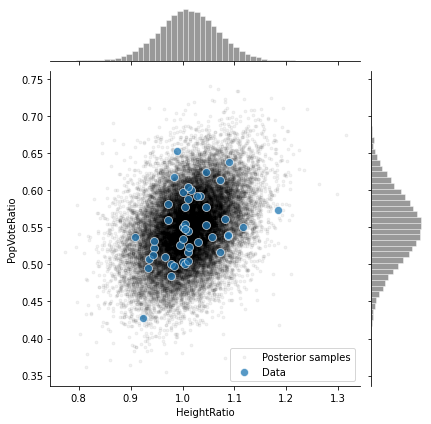

In [20]:
plot_density(full_prior_samples);

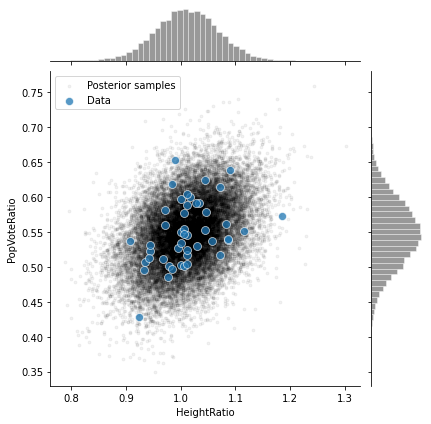

In [21]:
plot_density(positive_prior_samples);

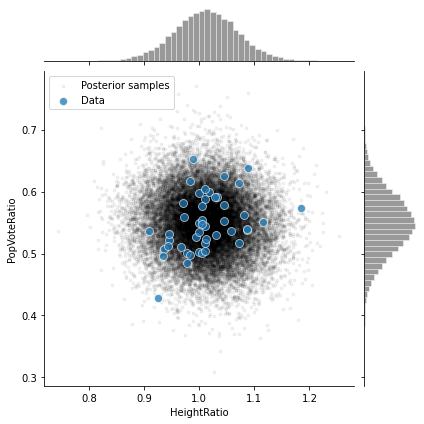

In [22]:
plot_density(negative_prior_samples);

## LKJ Model

You can find more details about the LKJ distribution and usage in the [PyMC3 examples](https://docs.pymc.io/notebooks/LKJ.html). Here, we use it as a weakly-informative 0-centered prior that supports more efficient sampling.

$$\mu_{height} \sim N(\mu=1, \sigma=.1)$$
$$\mu_{vote} \sim Beta(\mu=.5, \sigma=.25)$$

$$\sigma_{lkj} \sim HalfCauchy(\sigma=2.5)$$
$$\mathbf{L} \sim LKJ(\eta=2, \sigma=\sigma_{lkj})$$

$$\Sigma = \mathbf{L} \mathbf{L}^T$$

$$\mathbf{\mu} = \begin{bmatrix} \mu_{height} & \mu_{vote} \end{bmatrix}$$

$$height, vote \sim N(\mathbf{\mu}, \Sigma)$$

In [23]:
def create_LKJ_model(data=None, mu_height=None, mu_vote=None):
    with pm.Model() as model:
        # Sample from priors if not specified
        if mu_height is None:
            # Height is weirdly distributed, but seems to be close to 1
            mu_height = pm.Normal('mu_height', mu=1, sigma=.1)
            
        if mu_vote is None:
            # Vote is in (0, 1) and is a proportion, so I use beta distribution.
            mu_vote = pm.Beta('mu_vote', mu=.5, sigma=.25)
        
        # Covariance prior via Cholesky decomposition
        packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., 
                                     sd_dist=pm.HalfCauchy.dist(2.5))
        
        L = pm.expand_packed_triangular(2, packed_L)
        cov = pm.Deterministic('cov', L.dot(L.T))
        
        # Deterministically compute correlation matrix based on covariance
        diagonal = tt.diagonal(cov)
        denom = tt.sqrt(tt.prod(diagonal))
        corr = pm.Deterministic('corr', cov[0, 1] / denom)
                
        obs = pm.MvNormal("obs", mu=(mu_height, mu_vote), chol=L, observed=data)
        
    return model

In [24]:
lkj_model = create_LKJ_model(data=data)
lkj_trace = sample_from_model(lkj_model)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, mu_vote, mu_height]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:09<00:00, 1880.00draws/s]


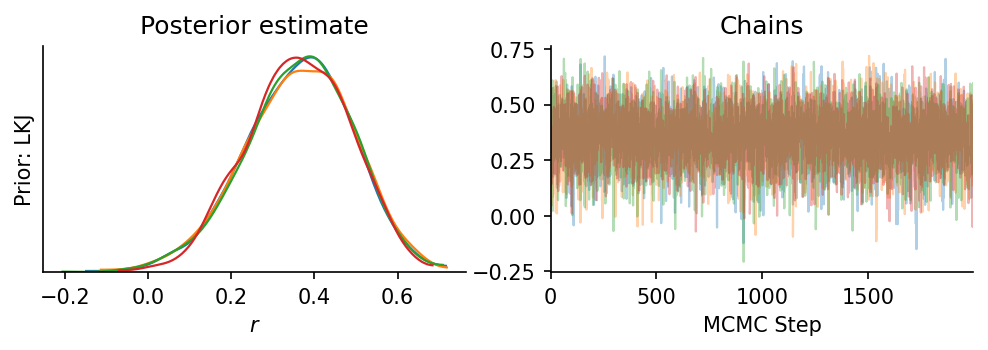

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2), dpi=150, 
                         sharex='col', sharey='col', squeeze=False)

az.plot_trace(lkj_trace, var_names='corr', ax=axes[0:1, :], )

plt.setp(axes, title='')
plt.setp(axes[0, 0], title='Posterior estimate', ylabel='Prior: LKJ', xlabel='$r$')
plt.setp(axes[0, 1], title='Chains', xlabel='MCMC Step')

sns.despine();

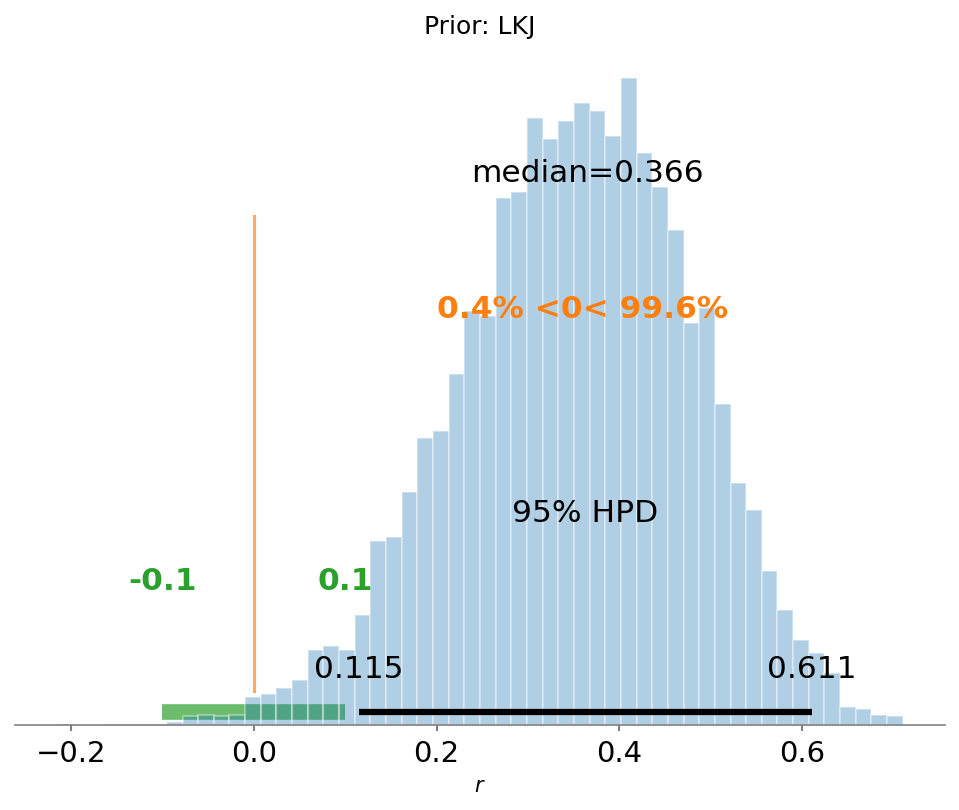

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6), dpi=150, 
                         sharex=True, sharey=True)

plot_posterior(lkj_trace, 'Prior: LKJ', axes)

plt.setp(axes, xlabel='$r$');

In [27]:
lkj_prior_samples = sample_posterior(lkj_model, lkj_trace)

100%|██████████| 25000/25000 [00:13<00:00, 1867.47it/s]


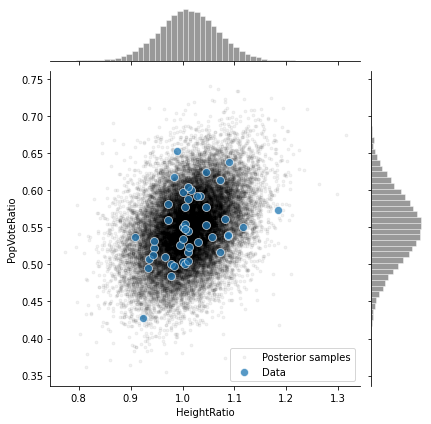

In [28]:
plot_density(full_prior_samples);